In [4]:
"""A base class for interval extracting forest estimators."""

__maintainer__ = []
__all__ = ["BaseIntervalForest"]

import inspect
import time
import warnings
from abc import ABC, abstractmethod

import numpy as np
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, is_classifier, is_regressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import BaseDecisionTree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import check_random_state

from aeon.base._base import _clone_estimator
from aeon.classification.sklearn import ContinuousIntervalTree
from aeon.transformations.base import BaseTransformer
from aeon.transformations.collection.interval_based import (
    RandomIntervals,
    SupervisedIntervals,
)
from aeon.utils.numba.stats import row_mean, row_slope, row_std
from aeon.utils.validation import check_n_jobs


class BaseIntervalForest(ABC):
    """A base class for interval extracting forest estimators.

    Allows the implementation of classifiers and regressors along the lines of [1][2][3]
    which extract intervals and create an ensemble from the subsequent features.

    Parameters
    ----------
    base_estimator : BaseEstimator or None, default=None
        scikit-learn BaseEstimator used to build the interval ensemble. If None, use a
        simple decision tree.
    n_estimators : int, default=200
        Number of estimators to build for the ensemble.
    interval_selection_method : "random", "supervised" or "random-supervised",
            default="random"
        The interval selection transformer to use.
            - "random" uses a RandomIntervalTransformer.
            - "supervised" uses a SupervisedIntervalTransformer.
            - "random-supervised" uses a SupervisedIntervalTransformer with
                randomised elements.

        Supervised methods can only be used for classification tasks, and require
        function inputs for interval_features rather than transformers.
    n_intervals : int, str, list or tuple, default="sqrt"
        Number of intervals to extract per tree for each series_transformers series.

        An int input will extract that number of intervals from the series, while a str
        input will return a function of the series length (may differ per
        series_transformers output) to extract that number of intervals.
        Valid str inputs are:
            - "sqrt": square root of the series length.
            - "sqrt-div": sqrt of series length divided by the number
                of series_transformers.

        A list or tuple of ints and/or strs will extract the number of intervals using
        the above rules and sum the results for the final n_intervals. i.e. [4, "sqrt"]
        will extract sqrt(n_timepoints) + 4 intervals.

        Different number of intervals for each series_transformers series can be
        specified using a nested list or tuple. Any list or tuple input containing
        another list or tuple must be the same length as the number of
        series_transformers.

        While random interval extraction will extract the n_intervals intervals total
        (removing duplicates), supervised intervals will run the supervised extraction
        process n_intervals times, returning more intervals than specified.
    min_interval_length : int, float, list, or tuple, default=3
        Minimum length of intervals to extract from series. float inputs take a
        proportion of the series length to use as the minimum interval length.

        Different minimum interval lengths for each series_transformers series can be
        specified using a list or tuple. Any list or tuple input must be the same length
        as the number of series_transformers.
    max_interval_length : int, float, list, or tuple, default=np.inf
        Maximum length of intervals to extract from series. float inputs take a
        proportion of the series length to use as the maximum interval length.

        Different maximum interval lengths for each series_transformers series can be
        specified using a list or tuple. Any list or tuple input must be the same length
        as the number of series_transformers.

        Ignored for supervised interval_selection_method inputs.
    interval_features : BaseTransformer, callable, list, tuple, or None, default=None
        The features to extract from the intervals using transformers or callable
        functions. If None, use the mean, standard deviation, and slope of the series.

        Both transformers and functions should be able to take a 2D np.ndarray input.
        Functions should output a 1d array (the feature for each series), and
        transformers should output a 2d array where rows are the features for each
        series. A list or tuple of transformers and/or functions will extract all
        features and concatenate the output.

        Different features for each series_transformers series can be specified using a
        nested list or tuple. Any list or tuple input containing another list or tuple
        must be the same length as the number of series_transformers.
    series_transformers : BaseTransformer, list, tuple, or None, default=None
        The transformers to apply to the series before extracting intervals. If None,
        use the series as is.

        A list or tuple of transformers will extract intervals from
        all transformations concatenate the output. Including None in the list or tuple
        will use the series as is for interval extraction.
    att_subsample_size : int, float, list, tuple or None, default=None
        The number of attributes to subsample for each estimator. If None, use all

        If int, use that number of attributes for all estimators. If float, use that
        proportion of attributes for all estimators.

        Different subsample sizes for each series_transformers series can be specified
        using a list or tuple. Any list or tuple input must be the same length as the
        number of series_transformers.
    replace_nan : "nan", int, float or None, default=None
        The value to replace NaNs and infinite values with before fitting the base
        estimator. int or float input will replace with the specified value, while
        "nan" will replace infinite values with NaNs. If None, do not replace NaNs.
    time_limit_in_minutes : int, default=0
        Time contract to limit build time in minutes, overriding n_estimators.
        Default of 0 means n_estimators are used.
    contract_max_n_estimators : int, default=500
        Max number of estimators when time_limit_in_minutes is set.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    parallel_backend : str, ParallelBackendBase instance or None, default=None
        Specify the parallelisation backend implementation in joblib, if None a 'prefer'
        value of "threads" is used by default.
        Valid options are "loky", "multiprocessing", "threading" or a custom backend.
        See the joblib Parallel documentation for more details.

    Attributes
    ----------
    n_cases_ : int
        The number of train cases.
    n_channels_ : int
        The number of channels per case.
    n_timepoints_ : int
        The length of each series.
    total_intervals_ : int
        Total number of intervals per tree from all representations.
    estimators_ : list of shape (n_estimators) of BaseEstimator
        The collections of estimators trained in fit.
    intervals_ : list of shape (n_estimators) of BaseTransformer
        Stores the interval extraction transformer for all estimators.

    References
    ----------
    .. [1] H.Deng, G.Runger, E.Tuv and M.Vladimir, "A time series forest for
       classification and feature extraction", Information Sciences, 239, 2013
    .. [2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical
       Interval Forest (CIF) Classifier for Time Series Classification."
       IEEE International Conference on Big Data 2020
    .. [3] Cabello, Nestor, et al. "Fast and Accurate Time Series Classification
       Through Supervised Interval Search." IEEE ICDM 2020
    """

    @abstractmethod
    def __init__(
        self,
        base_estimator=None,
        n_estimators=200,
        interval_selection_method="random",
        n_intervals="sqrt",
        min_interval_length=3,
        max_interval_length=np.inf,
        interval_features=None,
        series_transformers=None,
        att_subsample_size=None,
        replace_nan=None,
        time_limit_in_minutes=None,
        contract_max_n_estimators=500,
        random_state=None,
        n_jobs=1,
        parallel_backend=None,
    ):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.interval_selection_method = interval_selection_method
        self.n_intervals = n_intervals
        self.min_interval_length = min_interval_length
        self.max_interval_length = max_interval_length
        self.interval_features = interval_features
        self.series_transformers = series_transformers
        self.att_subsample_size = att_subsample_size
        self.replace_nan = replace_nan
        self.time_limit_in_minutes = time_limit_in_minutes
        self.contract_max_n_estimators = contract_max_n_estimators
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.parallel_backend = parallel_backend

        super().__init__()

    # if subsampling attributes, an interval_features transformer must contain a
    # parameter name from transformer_feature_selection and an attribute name
    # (or property) from transformer_feature_names to allow features to be subsampled
    transformer_feature_selection = ["features"]
    transformer_feature_names = [
        "features_arguments_",
        "_features_arguments",
        "get_features_arguments",
        "_get_features_arguments",
    ]
    # an interval_features transformer must contain one of these attribute names to
    # be able to skip transforming features in predict
    transformer_feature_skip = ["transform_features_", "_transform_features"]

    def _fit(self, X, y):
        if getattr(self, "__unit_test_flag", False):
            self._transformed_data = self._fit_forest(X, y, save_transformed_data=True)
        else:
            self._fit_forest(X, y)

        return self

    def _predict(self, X):
        if is_regressor(self):
            Xt = self._predict_setup(X)

            y_preds = Parallel(
                n_jobs=self._n_jobs,
                backend=self.parallel_backend,
                prefer="threads",
            )(
                delayed(self._predict_for_estimator)(
                    Xt,
                    self.estimators_[i],
                    self.intervals_[i],
                    predict_proba=False,
                )
                for i in range(self._n_estimators)
            )

            return np.mean(y_preds, axis=0)
        else:
            return np.array(
                [self.classes_[int(np.argmax(prob))] for prob in self._predict_proba(X)]
            )

    def _predict_proba(self, X):
        Xt = self._predict_setup(X)

        y_probas = Parallel(
            n_jobs=self._n_jobs, backend=self.parallel_backend, prefer="threads"
        )(
            delayed(self._predict_for_estimator)(
                Xt,
                self.estimators_[i],
                self.intervals_[i],
                predict_proba=True,
            )
            for i in range(self._n_estimators)
        )

        output = np.sum(y_probas, axis=0) / (
            np.ones(self.n_classes_) * self._n_estimators
        )
        return output

    def _fit_predict(self, X, y) -> np.ndarray:
        rng = check_random_state(self.random_state)

        if is_regressor(self):
            Xt = self._fit_forest(X, y, save_transformed_data=True)

            p = Parallel(
                n_jobs=self._n_jobs, backend=self.parallel_backend, prefer="threads"
            )(
                delayed(self._train_estimate_for_estimator)(
                    Xt,
                    y,
                    i,
                    check_random_state(rng.randint(np.iinfo(np.int32).max)),
                )
                for i in range(self._n_estimators)
            )
            y_preds, oobs = zip(*p)

            results = np.sum(y_preds, axis=0)
            divisors = np.zeros(self.n_cases_)
            for oob in oobs:
                for inst in oob:
                    divisors[inst] += 1

            label_average = np.mean(y)
            for i in range(self.n_cases_):
                results[i] = (
                    label_average if divisors[i] == 0 else results[i] / divisors[i]
                )
        else:
            return np.array(
                [
                    self.classes_[int(rng.choice(np.flatnonzero(prob == prob.max())))]
                    for prob in self._fit_predict_proba(X, y)
                ]
            )

        return results

    def _fit_predict_proba(self, X, y) -> np.ndarray:
        if is_regressor(self):
            raise ValueError(
                "Train probability estimates are only available for classification"
            )

        Xt = self._fit_forest(X, y, save_transformed_data=True)

        rng = check_random_state(self.random_state)

        p = Parallel(
            n_jobs=self._n_jobs, backend=self.parallel_backend, prefer="threads"
        )(
            delayed(self._train_estimate_for_estimator)(
                Xt,
                y,
                i,
                check_random_state(rng.randint(np.iinfo(np.int32).max)),
                probas=True,
            )
            for i in range(self._n_estimators)
        )
        y_probas, oobs = zip(*p)

        results = np.sum(y_probas, axis=0)
        divisors = np.zeros(self.n_cases_)
        for oob in oobs:
            for inst in oob:
                divisors[inst] += 1

        for i in range(self.n_cases_):
            results[i] = (
                np.ones(self.n_classes_) * (1 / self.n_classes_)
                if divisors[i] == 0
                else results[i] / (np.ones(self.n_classes_) * divisors[i])
            )

        return results

    def _fit_forest(self, X, y, save_transformed_data=False):
        rng = check_random_state(self.random_state)

        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        self._base_estimator = self.base_estimator
        if self.base_estimator is None:
            if is_classifier(self):
                self._base_estimator = DecisionTreeClassifier(criterion="entropy")
            elif is_regressor(self):
                self._base_estimator = DecisionTreeRegressor(criterion="absolute_error")
            else:
                raise ValueError(
                    f"{self} must be a scikit-learn compatible classifier or "
                    "regressor."
                )
        # base_estimator must be an sklearn estimator
        elif not isinstance(self.base_estimator, BaseEstimator):
            raise ValueError(
                "base_estimator must be a scikit-learn BaseEstimator or None. "
                f"Found: {self.base_estimator}"
            )

        # use the base series if series_transformers is None
        if self.series_transformers is None or self.series_transformers == []:
            Xt = [X]
            self._series_transformers = [None]
        # clone series_transformers if it is a transformer and transform the input data
        elif _is_transformer(self.series_transformers):
            t = _clone_estimator(self.series_transformers, random_state=rng)
            Xt = [t.fit_transform(X, y)]
            self._series_transformers = [t]
        # clone each series_transformers transformer and include the base series if None
        # is in the list
        elif isinstance(self.series_transformers, (list, tuple)):
            Xt = []
            self._series_transformers = []

            for transformer in self.series_transformers:
                if transformer is None:
                    Xt.append(X)
                    self._series_transformers.append(None)
                elif _is_transformer(transformer):
                    t = _clone_estimator(transformer, random_state=rng)
                    Xt.append(t.fit_transform(X, y))
                    self._series_transformers.append(t)
                else:
                    raise ValueError(
                        f"Invalid series_transformers list input. Found {transformer}"
                    )
        # other inputs are invalid
        else:
            raise ValueError(
                f"Invalid series_transformers input. Found {self.series_transformers}"
            )

        # if only a single n_intervals value is passed it must be an int or str
        if isinstance(self.n_intervals, (int, str)):
            n_intervals = [[self.n_intervals]] * len(Xt)
        elif isinstance(self.n_intervals, (list, tuple)):
            # if input is a list and only contains ints or strs, use the list for all
            # series in Xt
            if all(isinstance(item, (int, str)) for item in self.n_intervals):
                n_intervals = [self.n_intervals] * len(Xt)
            # other lists must be the same length as Xt
            elif len(self.n_intervals) != len(Xt):
                raise ValueError(
                    "n_intervals as a list or tuple containing other lists or tuples "
                    "must be the same length as series_transformers."
                )
            # list items can be a list of items or a single item for each
            # series_transformer, but each individual item must be an int or str
            else:
                n_intervals = []
                for items in self.n_intervals:
                    if isinstance(items, (list, tuple)):
                        if not all(isinstance(item, (int, str)) for item in items):
                            raise ValueError(
                                "Individual items in a n_intervals list or tuple must "
                                f"be an int or str. Input {items} does not contain "
                                "only ints or strs"
                            )
                        n_intervals.append(items)
                    elif isinstance(items, (int, str)):
                        n_intervals.append([items])
                    else:
                        raise ValueError(
                            "Individual items in a n_intervals list or tuple must be "
                            f"an int or str. Found: {items}"
                        )
        # other inputs are invalid
        else:
            raise ValueError(f"Invalid n_intervals input. Found {self.n_intervals}")

        # add together the number of intervals for each series_transformer
        # str input must be one of a set valid options
        self._n_intervals = [0] * len(Xt)
        for i, series in enumerate(Xt):
            for method in n_intervals[i]:
                if isinstance(method, int):
                    self._n_intervals[i] += method
                elif isinstance(method, str):
                    # sqrt of series length
                    if method.lower() == "sqrt":
                        self._n_intervals[i] += int(
                            np.sqrt(series.shape[2]) * np.sqrt(series.shape[1])
                        )
                    # sqrt of series length divided by the number of series_transformers
                    elif method.lower() == "sqrt-div":
                        self._n_intervals[i] += int(
                            (np.sqrt(series.shape[2]) * np.sqrt(series.shape[1]))
                            / len(Xt)
                        )
                    else:
                        raise ValueError(
                            "Invalid str input for n_intervals. Must be "
                            f'("sqrt","sqrt-div"). Found {method}'
                        )

        # each series_transformer must have at least 1 interval extracted
        for i, n in enumerate(self._n_intervals):
            if n <= 0:
                self._n_intervals[i] = 1

        self.total_intervals_ = sum(self._n_intervals)

        # minimum interval length
        if isinstance(self.min_interval_length, int):
            self._min_interval_length = [self.min_interval_length] * len(Xt)
        # min_interval_length must be less than one if it is a float (proportion of
        # of the series length)
        elif (
            isinstance(self.min_interval_length, float)
            and self.min_interval_length <= 1
        ):
            self._min_interval_length = [
                int(self.min_interval_length * t.shape[2]) for t in Xt
            ]
        # if the input is a list, it must be the same length as the number of
        # series_transformers
        # list values must be ints or floats. The same checks as above are performed
        elif isinstance(self.min_interval_length, (list, tuple)):
            if len(self.min_interval_length) != len(Xt):
                raise ValueError(
                    "min_interval_length as a list or tuple must be the same length "
                    "as series_transformers."
                )

            self._min_interval_length = []
            for i, length in enumerate(self.min_interval_length):
                if isinstance(length, float) and length <= 1:
                    self._min_interval_length.append(int(length * Xt[i].shape[2]))
                elif isinstance(length, int):
                    self._min_interval_length.append(length)
                else:
                    raise ValueError(
                        "min_interval_length list items must be int or floats. "
                        f"Found {length}"
                    )
        # other inputs are invalid
        else:
            raise ValueError(
                f"Invalid min_interval_length input. Found {self.min_interval_length}"
            )

        # min_interval_length cannot be less than 3 or greater than the series length
        for i, n in enumerate(self._min_interval_length):
            if n > Xt[i].shape[2]:
                self._min_interval_length[i] = Xt[i].shape[2]
            elif n < 3:
                self._min_interval_length[i] = 3

        # maximum interval length
        if (
            isinstance(self.max_interval_length, int)
            or self.max_interval_length == np.inf
        ):
            self._max_interval_length = [self.max_interval_length] * len(Xt)
        # max_interval_length must be at less than one if it is a float  (proportion of
        # of the series length)
        elif (
            isinstance(self.max_interval_length, float)
            and self.max_interval_length <= 1
        ):
            self._max_interval_length = [
                int(self.max_interval_length * t.shape[2]) for t in Xt
            ]
        # if the input is a list, it must be the same length as the number of
        # series_transformers
        # list values must be ints or floats. The same checks as above are performed
        elif isinstance(self.max_interval_length, (list, tuple)):
            if len(self.max_interval_length) != len(Xt):
                raise ValueError(
                    "max_interval_length as a list or tuple must be the same length "
                    "as series_transformers."
                )

            self._max_interval_length = []
            for i, length in enumerate(self.max_interval_length):
                if isinstance(length, float) and length <= 1:
                    self._max_interval_length.append(int(length * Xt[i].shape[2]))
                elif isinstance(length, int):
                    self._max_interval_length.append(length)
                else:
                    raise ValueError(
                        "max_interval_length list items must be int or floats. "
                        f"Found {length}"
                    )
        # other inputs are invalid
        else:
            raise ValueError(
                f"Invalid max_interval_length input. Found {self.max_interval_length}"
            )

        # max_interval_length cannot be less than min_interval_length or greater than
        # the series length
        for i, n in enumerate(self._max_interval_length):
            if n < self._min_interval_length[i]:
                self._max_interval_length[i] = self._min_interval_length[i]
            elif n > Xt[i].shape[2]:
                self._max_interval_length[i] = Xt[i].shape[2]

        # we store whether each series_transformer contains a transformer and/or
        # function in its interval_features
        self._interval_transformer = [False] * len(Xt)
        self._interval_function = [False] * len(Xt)
        # single transformer or function for all series_transformers
        if isinstance(self.interval_features, BaseTransformer):
            self._interval_transformer = [True] * len(Xt)
            transformer = _clone_estimator(self.interval_features, random_state=rng)
            self._interval_features = [[transformer]] * len(Xt)
        elif callable(self.interval_features):
            self._interval_function = [True] * len(Xt)
            self._interval_features = [[self.interval_features]] * len(Xt)
        elif isinstance(self.interval_features, (list, tuple)):
            # if input is a list and only contains transformers or functions, use the
            # list for all series in Xt
            if all(
                isinstance(item, BaseTransformer) or callable(item)
                for item in self.interval_features
            ):
                for feature in self.interval_features:
                    if isinstance(feature, BaseTransformer):
                        self._interval_transformer[0] = True
                    elif callable(feature):
                        self._interval_function[0] = True
                self._interval_features = [self.interval_features] * len(Xt)
            # other lists must be the same length as Xt
            elif len(self.interval_features) != len(Xt):
                raise ValueError(
                    "interval_features as a list or tuple containing other lists or "
                    "tuples must be the same length as series_transformers."
                )
            # list items can be a list of items or a single item for each
            # series_transformer, but each individual item must be a transformer
            # or function
            else:
                self._interval_features = []
                for i, feature in enumerate(self.interval_features):
                    if isinstance(feature, (list, tuple)):
                        for method in feature:
                            if isinstance(method, BaseTransformer):
                                self._interval_transformer[i] = True
                                feature = _clone_estimator(feature, random_state=rng)
                            elif callable(method):
                                self._interval_function[i] = True
                            else:
                                raise ValueError(
                                    "Individual items in a interval_features list or "
                                    "tuple must be a transformer or function. Input "
                                    f"{feature} does not contain only transformers and "
                                    f"functions."
                                )
                        self._interval_features.append(feature)
                    elif isinstance(feature, BaseTransformer):
                        self._interval_transformer[i] = True
                        feature = _clone_estimator(feature, random_state=rng)
                        self._interval_features.append([feature])
                    elif callable(feature):
                        self._interval_function[i] = True
                        self._interval_features.append([feature])
                    else:
                        raise ValueError(
                            "Individual items in a interval_features list or tuple "
                            f"must be a transformer or function. Found {feature}"
                        )
        # use basic summary stats by default if None
        elif self.interval_features is None:
            self._interval_function = [True] * len(Xt)
            self._interval_features = [[row_mean, row_std, row_slope]] * len(Xt)
        # other inputs are invalid
        else:
            raise ValueError(
                f"Invalid interval_features input. Found {self.interval_features}"
            )

        # att_subsample_size must be at least one if it is an int
        if isinstance(self.att_subsample_size, int):
            if self.att_subsample_size < 1:
                raise ValueError(
                    "att_subsample_size must be at least one if it is an int."
                )

            self._att_subsample_size = [self.att_subsample_size] * len(Xt)
        # att_subsample_size must be at less than one if it is a float (proportion of
        # total attributed to subsample)
        elif isinstance(self.att_subsample_size, float):
            if self.att_subsample_size > 1 or self.att_subsample_size <= 0:
                raise ValueError(
                    "att_subsample_size must be between 0 and 1 if it is a float."
                )

            self._att_subsample_size = [self.att_subsample_size] * len(Xt)
        # default is no attribute subsampling with None
        elif self.att_subsample_size is None:
            self._att_subsample_size = [self.att_subsample_size] * len(Xt)
        # if the input is a list, it must be the same length as the number of
        # series_transformers
        # list values must be ints, floats or None. The same checks as above are
        # performed
        elif isinstance(self.att_subsample_size, (list, tuple)):
            if len(self.att_subsample_size) != len(Xt):
                raise ValueError(
                    "att_subsample_size as a list or tuple must be the same length as "
                    "series_transformers."
                )

            self._att_subsample_size = []
            for ssize in self.att_subsample_size:
                if isinstance(ssize, int):
                    if ssize < 1:
                        raise ValueError(
                            "att_subsample_size in list must be at least one if it is "
                            "an int."
                        )

                    self._att_subsample_size.append(ssize)
                elif isinstance(ssize, float):
                    if ssize > 1:
                        raise ValueError(
                            "att_subsample_size in list must be between 0 and 1 if it "
                            "is a "
                            "float."
                        )

                    self._att_subsample_size.append(ssize)
                elif ssize is None:
                    self._att_subsample_size.append(ssize)
                else:
                    raise ValueError(
                        "Invalid interval_features input in list. Found "
                        f"{self.att_subsample_size}"
                    )
        # other inputs are invalid
        else:
            raise ValueError(
                f"Invalid interval_features input. Found {self.att_subsample_size}"
            )

        # if we are subsampling attributes for a series_transformer and it uses a
        # BaseTransformer, we must ensure it has the required parameters and
        # attributes to do so
        self._transformer_feature_selection = [[]] * len(Xt)
        self._transformer_feature_names = [[]] * len(Xt)
        for r, att_subsample in enumerate(self._att_subsample_size):
            if att_subsample is not None:
                for transformer in self._interval_features[r]:
                    if isinstance(transformer, BaseTransformer):
                        params = inspect.signature(transformer.__init__).parameters

                        # the transformer must have a parameter with one of the
                        # names listed in transformer_feature_selection as a way to
                        # select which features the transformer should transform
                        has_params = False
                        for n in self.transformer_feature_selection:
                            if params.get(n, None) is not None:
                                has_params = True
                                self._transformer_feature_selection[r].append(n)
                                break

                        if not has_params:
                            raise ValueError(
                                "All transformers in interval_features must have a "
                                "parameter named in transformer_feature_selection to "
                                "be used in attribute subsampling."
                            )

                        # the transformer must have an attribute with one of the
                        # names listed in transformer_feature_names as a list or tuple
                        # of valid options for the previous parameter
                        has_feature_names = False
                        for n in self.transformer_feature_names:
                            if hasattr(transformer, n) and isinstance(
                                getattr(transformer, n), (list, tuple)
                            ):
                                has_feature_names = True
                                self._transformer_feature_names[r].append(n)
                                break

                        if not has_feature_names:
                            raise ValueError(
                                "All transformers in interval_features must have an "
                                "attribute or property named in "
                                "transformer_feature_names to be used in attribute "
                                "subsampling."
                            )

        # verify the interval_selection_method is a valid string
        if isinstance(self.interval_selection_method, str):
            # SupervisedIntervals cannot currently handle transformers or regression
            if (
                self.interval_selection_method.lower() == "supervised"
                or self.interval_selection_method.lower() == "random-supervised"
            ):
                if any(self._interval_transformer):
                    raise ValueError(
                        "Supervised interval_selection_method must only have function "
                        "inputs for interval_features."
                    )

                if is_regressor(self):
                    raise ValueError(
                        "Supervised interval_selection_method cannot be used for "
                        "regression."
                    )
            # RandomIntervals
            elif not self.interval_selection_method.lower() == "random":
                raise ValueError(
                    'Unknown interval_selection_method, must be one of ("random",'
                    '"supervised","random-supervised"). '
                    f"Found: {self.interval_selection_method}"
                )
        # other inputs are invalid
        else:
            raise ValueError(
                'Unknown interval_selection_method, must be one of ("random",'
                '"supervised","random-supervised"). '
                f"Found: {self.interval_selection_method}"
            )

        # verify replace_nan is a valid string, number or None
        if (
            (not isinstance(self.replace_nan, str) or self.replace_nan.lower() != "nan")
            and not isinstance(self.replace_nan, (int, float))
            and self.replace_nan is not None
        ):
            raise ValueError(f"Invalid replace_nan input. Found {self.replace_nan}")

        self._n_jobs = check_n_jobs(self.n_jobs)

        if self.time_limit_in_minutes is not None and self.time_limit_in_minutes > 0:
            time_limit = self.time_limit_in_minutes * 60
            start_time = time.time()
            train_time = 0

            self._n_estimators = 0
            self.estimators_ = []
            self.intervals_ = []
            transformed_intervals = []

            while (
                train_time < time_limit
                and self._n_estimators < self.contract_max_n_estimators
            ):
                fit = Parallel(
                    n_jobs=self._n_jobs,
                    backend=self.parallel_backend,
                    prefer="threads",
                )(
                    delayed(self._fit_estimator)(
                        Xt,
                        y,
                        rng.randint(np.iinfo(np.int32).max),
                        save_transformed_data=save_transformed_data,
                    )
                    for _ in range(self._n_jobs)
                )

                (
                    estimators,
                    intervals,
                    td,
                ) = zip(*fit)

                self.estimators_ += estimators
                self.intervals_ += intervals
                transformed_intervals += td

                self._n_estimators += self._n_jobs
                train_time = time.time() - start_time
        else:
            self._n_estimators = self.n_estimators

            fit = Parallel(
                n_jobs=self._n_jobs,
                backend=self.parallel_backend,
                prefer="threads",
            )(
                delayed(self._fit_estimator)(
                    Xt,
                    y,
                    rng.randint(np.iinfo(np.int32).max),
                    save_transformed_data=save_transformed_data,
                )
                for _ in range(self._n_estimators)
            )

            (
                self.estimators_,
                self.intervals_,
                transformed_intervals,
            ) = zip(*fit)

        return transformed_intervals

    def _fit_estimator(self, Xt, y, seed, save_transformed_data=False):
        # random state for this estimator
        rng = check_random_state(seed)

        intervals = []
        transform_data_lengths = []
        interval_features = np.empty((self.n_cases_, 0))

        # for each transformed series
        for r in range(len(Xt)):
            # subsample attributes if enabled
            if self._att_subsample_size[r] is not None:
                # separate transformers and functions in separate lists
                # add the feature names of transformers to a list to subsample from
                # and calculate the total number of features
                all_transformers = []
                all_transformer_features = []
                all_function_features = []
                for feature in self._interval_features[r]:
                    if isinstance(feature, BaseTransformer):
                        all_transformer_features += getattr(
                            feature,
                            self._transformer_feature_names[r][len(all_transformers)],
                        )
                        all_transformers.append(feature)
                    else:
                        all_function_features.append(feature)

                # handle float subsample size
                num_features = len(all_transformer_features) + len(
                    all_function_features
                )
                att_subsample_size = self._att_subsample_size[r]
                if isinstance(self._att_subsample_size[r], float):
                    att_subsample_size = int(att_subsample_size * num_features)

                # if the att_subsample_size is greater than the number of features
                # give a warning and add all features
                features = []
                if att_subsample_size < num_features:
                    # subsample the transformer and function features by index
                    atts = rng.choice(
                        num_features,
                        att_subsample_size,
                        replace=False,
                    )
                    atts.sort()

                    # subsample the feature transformers using the
                    # transformer_feature_names and transformer_feature_selection
                    # attributes.
                    # the presence of valid attributes is verified in fit.
                    count = 0
                    length = 0
                    for n, transformer in enumerate(all_transformers):
                        this_len = len(
                            getattr(transformer, self._transformer_feature_names[r][n])
                        )
                        length += this_len

                        # subsample feature names from this transformer
                        t_features = []
                        while count < len(atts) and atts[count] < length:
                            t_features.append(
                                getattr(
                                    transformer,
                                    self._transformer_feature_names[r][n],
                                )[atts[count] + this_len - length]
                            )
                            count += 1

                        # tell this transformer to only transform the selected features
                        if len(t_features) > 0:
                            new_transformer = _clone_estimator(transformer, seed)
                            setattr(
                                new_transformer,
                                self._transformer_feature_selection[r][n],
                                t_features,
                            )
                            features.append(new_transformer)

                    # subsample the remaining function features
                    for i in range(att_subsample_size - count):
                        features.append(all_function_features[atts[count + i] - length])
                else:
                    # only warn if requested number of features is greater than actual
                    if att_subsample_size > num_features:
                        warnings.warn(
                            f"Attribute subsample size {att_subsample_size} is "
                            f"larger than the number of attributes {num_features} "
                            f"for series {self._series_transformers[r]}",
                            stacklevel=2,
                        )

                    self._att_subsample_size[r] = None

                    for feature in self._interval_features[r]:
                        if isinstance(feature, BaseTransformer):
                            features.append(_clone_estimator(feature, seed))
                        else:
                            features.append(feature)
            # add all features while cloning estimators if not subsampling
            else:
                features = []
                for feature in self._interval_features[r]:
                    if isinstance(feature, BaseTransformer):
                        features.append(_clone_estimator(feature, seed))
                    else:
                        features.append(feature)

            # create the selected interval selector and set its parameters
            if self.interval_selection_method == "random":
                selector = RandomIntervals(
                    n_intervals=self._n_intervals[r],
                    min_interval_length=self._min_interval_length[r],
                    max_interval_length=self._max_interval_length[r],
                    features=features,
                    random_state=seed,
                )
            elif self.interval_selection_method == "supervised":
                selector = SupervisedIntervals(
                    n_intervals=self._n_intervals[r],
                    min_interval_length=self._min_interval_length[r],
                    features=features,
                    randomised_split_point=False,
                    random_state=seed,
                )
            elif self.interval_selection_method == "random-supervised":
                selector = SupervisedIntervals(
                    n_intervals=self._n_intervals[r],
                    min_interval_length=self._min_interval_length[r],
                    features=features,
                    randomised_split_point=True,
                    random_state=seed,
                )

            # fit the interval selector, transform the current series using it and save
            # the transformer
            intervals.append(selector)
            f = intervals[r].fit_transform(Xt[r], y)

            # concatenate the data and save this transforms number of attributes
            transform_data_lengths.append(f.shape[1])
            interval_features = np.hstack((interval_features, f))

        if isinstance(self.replace_nan, str) and self.replace_nan.lower() == "nan":
            interval_features = np.nan_to_num(
                interval_features, False, np.nan, np.nan, np.nan
            )
        elif isinstance(self.replace_nan, (int, float)):
            interval_features = np.nan_to_num(
                interval_features,
                False,
                self.replace_nan,
                self.replace_nan,
                self.replace_nan,
            )

        # clone and fit the base estimator using the transformed data
        tree = _clone_estimator(self._base_estimator, random_state=seed)
        tree.fit(interval_features, y)

        # find the features used in the tree and inform the interval selectors to not
        # transform these features if possible
        self._efficient_predictions = True
        relevant_features = None
        if isinstance(tree, BaseDecisionTree):
            relevant_features = np.unique(tree.tree_.feature[tree.tree_.feature >= 0])
        elif isinstance(tree, ContinuousIntervalTree):
            relevant_features, _ = tree.tree_node_splits_and_gain()

        if relevant_features is not None:
            features_to_transform = [False] * interval_features.shape[1]
            for i in relevant_features:
                features_to_transform[i] = True

            count = 0
            for r in range(len(Xt)):
                intervals[r].transformer_feature_skip = self.transformer_feature_skip

                # if the transformers don't have valid attributes to skip False is
                # returned
                completed = intervals[r].set_features_to_transform(
                    features_to_transform[count : count + transform_data_lengths[r]],
                    raise_error=False,
                )
                count += transform_data_lengths[r]

                if not completed:
                    self._efficient_predictions = False
        else:
            self._efficient_predictions = False

        return [
            tree,
            intervals,
            interval_features if save_transformed_data else None,
        ]

    def _predict_setup(self, X):
        Xt = []
        for transformer in self._series_transformers:
            if transformer is None:
                Xt.append(X)
            elif _is_transformer(transformer):
                Xt.append(transformer.transform(X))

        return Xt

    def _predict_for_estimator(self, Xt, estimator, intervals, predict_proba=False):
        interval_features = np.empty((Xt[0].shape[0], 0))

        for r in range(len(Xt)):
            f = intervals[r].transform(Xt[r])
            interval_features = np.hstack((interval_features, f))

        if isinstance(self.replace_nan, str) and self.replace_nan.lower() == "nan":
            interval_features = np.nan_to_num(
                interval_features, False, np.nan, np.nan, np.nan
            )
        elif isinstance(self.replace_nan, (int, float)):
            interval_features = np.nan_to_num(
                interval_features,
                False,
                self.replace_nan,
                self.replace_nan,
                self.replace_nan,
            )

        if predict_proba:
            return estimator.predict_proba(interval_features)
        else:
            return estimator.predict(interval_features)

    def _train_estimate_for_estimator(self, Xt, y, idx, rng, probas=False):
        indices = range(self.n_cases_)
        subsample = rng.choice(self.n_cases_, size=self.n_cases_)
        oob = [n for n in indices if n not in subsample]

        results = (
            np.zeros((self.n_cases_, self.n_classes_))
            if probas
            else np.zeros(self.n_cases_)
        )
        if len(oob) == 0:
            return [results, oob]

        clf = _clone_estimator(self._base_estimator, rng)
        clf.fit(Xt[idx][subsample], y[subsample])
        preds = clf.predict_proba(Xt[idx][oob]) if probas else clf.predict(Xt[idx][oob])

        if probas and preds.shape[1] != self.n_classes_:
            new_probas = np.zeros((preds.shape[0], self.n_classes_))
            for i, cls in enumerate(clf.classes_):
                cls_idx = self._class_dictionary[cls]
                new_probas[:, cls_idx] = preds[:, i]
            preds = new_probas

        if probas:
            for n, proba in enumerate(preds):
                results[oob[n]] += proba
        else:
            for n, pred in enumerate(preds):
                results[oob[n]] = pred

        return [results, oob]

    def temporal_importance_curves(
        self, return_dict=False, normalise_time_points=False
    ):
        """Calculate the temporal importance curves for each feature.

        Can be finicky with transformers currently.

        Parameters
        ----------
        return_dict : bool, default=False
            If True, return a dictionary of curves. If False, return a list of names
            and a list of curves.
        normalise_time_points : bool, default=False
            If True, normalise the time points for each feature to the number of
            splits that used that feature. If False, return the sum of the information
            gain for each split.

        Returns
        -------
        names : list of str
            The names of the features.
        curves : list of np.ndarray
            The temporal importance curves for each feature.
        """
        if is_regressor(self):
            raise NotImplementedError(
                "Temporal importance curves are not available for regression."
            )
        if not isinstance(self._base_estimator, ContinuousIntervalTree):
            raise ValueError(
                "base_estimator for temporal importance curves must"
                " be ContinuousIntervalTree."
            )

        curves = {}
        if normalise_time_points:
            counts = {}

        for i, est in enumerate(self.estimators_):
            splits, gains = est.tree_node_splits_and_gain()
            split_features = []

            for n, rep in enumerate(self.intervals_[i]):
                t = 0
                rep_name = (
                    ""
                    if self._series_transformers[n] is None
                    else self._series_transformers[n].__class__.__name__
                )

                for interval in rep.intervals_:
                    if _is_transformer(interval[3]):
                        if self._att_subsample_size[n] is None:
                            names = None
                            for f in self.transformer_feature_names:
                                if hasattr(interval[3], f) and isinstance(
                                    getattr(interval[3], f), (list, tuple)
                                ):
                                    names = getattr(interval[3], f)
                                    break

                            if names is None:
                                raise ValueError(
                                    "All transformers in interval_features must have "
                                    "an attribute or property named in "
                                    "transformer_feature_names to be used in temporal "
                                    "importance curves."
                                )
                        else:
                            if t % len(self._interval_features[n]) - 1 == 0:
                                t = 0

                            names = getattr(
                                interval[3], self._transformer_feature_names[n][t]
                            )
                            t += 1

                        split_features.extend(
                            [
                                (
                                    rep_name,
                                    interval[0],
                                    interval[1],
                                    interval[2],
                                    feature_name,
                                )
                                for feature_name in names
                            ]
                        )
                    else:
                        split_features.append(
                            (
                                rep_name,
                                interval[0],
                                interval[1],
                                interval[2],
                                interval[3].__name__,
                            )
                        )

            for n, split in enumerate(splits):
                feature = (
                    split_features[split][0],
                    split_features[split][3],
                    split_features[split][4],
                )

                if feature not in curves:
                    curves[feature] = np.zeros(self.n_timepoints_)
                    curves[feature][
                        split_features[split][1] : split_features[split][2]
                    ] = gains[n]

                    if normalise_time_points:
                        counts[feature] = np.zeros(self.n_timepoints_)
                        counts[feature][
                            split_features[split][1] : split_features[split][2]
                        ] = 1
                else:
                    curves[feature][
                        split_features[split][1] : split_features[split][2]
                    ] += gains[n]

                    if normalise_time_points:
                        counts[feature][
                            split_features[split][1] : split_features[split][2]
                        ] += 1

        if normalise_time_points:
            for feature in counts:
                curves[feature] /= counts[feature]

        if return_dict:
            return curves
        else:
            names = []
            values = []
            for key, value in curves.items():
                dim = f"_dim{key[1]}" if self.n_channels_ > 1 else ""
                rep = f"{key[0]}_" if key[0] != "" else ""
                names.append(f"{rep}{key[2]}{dim}")
                values.append(value)

            names, values = zip(*sorted(zip(names, values)))

            return names, values


def _is_transformer(obj):
    if isinstance(obj, BaseTransformer) or isinstance(obj, FunctionTransformer):
        return True
    return False

In [5]:
"""DrCIF classifier.

Interval-based DrCIF classifier extracting catch22 features from random intervals on
periodogram and differences representations as well as the base series.
"""

__maintainer__ = []
__all__ = ["DrCIFClassifier"]

import numpy as np
from sklearn.preprocessing import FunctionTransformer

#from aeon.base._estimators.interval_based import BaseIntervalForest
from aeon.classification.base import BaseClassifier
from aeon.classification.sklearn._continuous_interval_tree import ContinuousIntervalTree
from aeon.transformations.collection import PeriodogramTransformer
from aeon.transformations.collection.feature_based import Catch22
from aeon.utils.numba.general import first_order_differences_3d
from aeon.utils.numba.stats import (
    row_iqr,
    row_mean,
    row_median,
    row_numba_max,
    row_numba_min,
    row_slope,
    row_std,
)


class DrCIFClassifier(BaseIntervalForest, BaseClassifier):
    """
    Diverse Representation Canonical Interval Forest Classifier (DrCIF).

    Extension of the CIF algorithm using multiple representations. Implementation of the
    interval-based forest making use of the catch22 feature set on randomly selected
    intervals on the base series, periodogram representation and differences
    representation described in the HIVE-COTE 2.0 paper Middlehurst et al (2021). [1]_

    Overview: Input "n" series with "d" dimensions of length "m".
    For each tree
        - Sample n_intervals intervals per representation of random position and length
        - Subsample att_subsample_size catch22 or summary statistic attributes randomly
        - Randomly select dimension for each interval
        - Calculate attributes for each interval from its representation, concatenate
          to form new data set
        - Build a decision tree on new data set
    Ensemble the trees with averaged probability estimates

    Parameters
    ----------
    base_estimator : BaseEstimator or None, default=None
        scikit-learn BaseEstimator used to build the interval ensemble. If None, use a
        simple decision tree.
    n_estimators : int, default=200
        Number of estimators to build for the ensemble.
    n_intervals : int, str, list or tuple, default="sqrt"
        Number of intervals to extract per tree for each series_transformers series.

        An int input will extract that number of intervals from the series, while a str
        input will return a function of the series length (may differ per
        series_transformers output) to extract that number of intervals.
        Valid str inputs are:
            - "sqrt": square root of the series length.
            - "sqrt-div": sqrt of series length divided by the number
                of series_transformers.

        A list or tuple of ints and/or strs will extract the number of intervals using
        the above rules and sum the results for the final n_intervals. i.e. [4, "sqrt"]
        will extract sqrt(n_timepoints) + 4 intervals.

        Different number of intervals for each series_transformers series can be
        specified using a nested list or tuple. Any list or tuple input containing
        another list or tuple must be the same length as the number of
        series_transformers.

        While random interval extraction will extract the n_intervals intervals total
        (removing duplicates), supervised intervals will run the supervised extraction
        process n_intervals times, returning more intervals than specified.
    min_interval_length : int, float, list, or tuple, default=3
        Minimum length of intervals to extract from series. float inputs take a
        proportion of the series length to use as the minimum interval length.

        Different minimum interval lengths for each series_transformers series can be
        specified using a list or tuple. Any list or tuple input must be the same length
        as the number of series_transformers.
    max_interval_length : int, float, list, or tuple, default=np.inf
        Maximum length of intervals to extract from series. float inputs take a
        proportion of the series length to use as the maximum interval length.

        Different maximum interval lengths for each series_transformers series can be
        specified using a list or tuple. Any list or tuple input must be the same length
        as the number of series_transformers.

        Ignored for supervised interval_selection_method inputs.
    att_subsample_size : int, float, list, tuple or None, default=None
        The number of attributes to subsample for each estimator. If None, use all

        If int, use that number of attributes for all estimators. If float, use that
        proportion of attributes for all estimators.

        Different subsample sizes for each series_transformers series can be specified
        using a list or tuple. Any list or tuple input must be the same length as the
        number of series_transformers.
    time_limit_in_minutes : int, default=0
        Time contract to limit build time in minutes, overriding n_estimators.
        Default of 0 means n_estimators are used.
    contract_max_n_estimators : int, default=500
        Max number of estimators when time_limit_in_minutes is set.
    use_pycatch22 : bool, optional, default=False
        Wraps the C based pycatch22 implementation for aeon.
        (https://github.com/DynamicsAndNeuralSystems/pycatch22). This requires the
        ``pycatch22`` package to be installed if True.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    parallel_backend : str, ParallelBackendBase instance or None, default=None
        Specify the parallelisation backend implementation in joblib, if None a 'prefer'
        value of "threads" is used by default.
        Valid options are "loky", "multiprocessing", "threading" or a custom backend.
        See the joblib Parallel documentation for more details.

    Attributes
    ----------
    n_cases_ : int
        The number of train cases in the training set.
    n_channels_ : int
        The number of dimensions per case in the training set.
    n_timepoints_ : int
        The length of each series in the training set.
    n_classes_ : int
        Number of classes. Extracted from the data.
    classes_ : ndarray of shape (n_classes_)
        Holds the label for each class.
    total_intervals_ : int
        Total number of intervals per tree from all representations.
    estimators_ : list of shape (n_estimators) of BaseEstimator
        The collections of estimators trained in fit.
    intervals_ : list of shape (n_estimators) of TransformerMixin
        Stores the interval extraction transformer for all estimators.

    See Also
    --------
    DrCIFRegressor
    CanonicalIntervalForestClassifier

    Notes
    -----
    For the Java version, see
    `TSML <https://github.com/uea-machine-learning/tsml/blob/master/src/main/java
    /tsml/classifiers/interval_based/DrCIF.java>`_.

    References
    ----------
    .. [1] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom,
       and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series
       classification." arXiv preprint arXiv:2104.07551 (2021).

    Examples
    --------
    >>> from aeon.classification.interval_based import DrCIFClassifier
    >>> from aeon.testing.data_generation import make_example_3d_numpy
    >>> X, y = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=12,
    ...                              return_y=True, random_state=0)
    >>> clf = DrCIFClassifier(n_estimators=10, random_state=0)
    >>> clf.fit(X, y)
    DrCIFClassifier(n_estimators=10, random_state=0)
    >>> clf.predict(X)
    array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])
    """

    _tags = {
        "capability:multivariate": True,
        "capability:train_estimate": True,
        "capability:contractable": True,
        "capability:multithreading": True,
        "algorithm_type": "interval",
    }

    def __init__(
        self,
        base_estimator=None,
        n_estimators=200,
        n_intervals=(4, "sqrt-div"),
        min_interval_length=3,
        max_interval_length=0.5,
        att_subsample_size=10,
        time_limit_in_minutes=None,
        contract_max_n_estimators=500,
        use_pycatch22=False,
        random_state=None,
        n_jobs=1,
        parallel_backend=None,
    ):
        self.use_pycatch22 = use_pycatch22

        if isinstance(base_estimator, ContinuousIntervalTree):
            replace_nan = "nan"
        else:
            replace_nan = 0

        series_transformers = [
            None,
            FunctionTransformer(func=first_order_differences_3d, validate=False),
            PeriodogramTransformer(),
        ]

        interval_features = [
            Catch22(outlier_norm=True, use_pycatch22=use_pycatch22),
            row_mean,
            row_std,
            row_slope,
            row_median,
            row_iqr,
            row_numba_min,
            row_numba_max,
        ]

        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            interval_selection_method="random",
            n_intervals=n_intervals,
            min_interval_length=min_interval_length,
            max_interval_length=max_interval_length,
            interval_features=interval_features,
            series_transformers=series_transformers,
            att_subsample_size=att_subsample_size,
            replace_nan=replace_nan,
            time_limit_in_minutes=time_limit_in_minutes,
            contract_max_n_estimators=contract_max_n_estimators,
            random_state=random_state,
            n_jobs=n_jobs,
            parallel_backend=parallel_backend,
        )

        if use_pycatch22:
            self.set_tags(**{"python_dependencies": "pycatch22"})

    def _fit(self, X, y):
        return super()._fit(X, y)

    def _predict(self, X) -> np.ndarray:
        return super()._predict(X)

    def _predict_proba(self, X) -> np.ndarray:
        return super()._predict_proba(X)

    def _fit_predict(self, X, y) -> np.ndarray:
        return super()._fit_predict(X, y)

    def _fit_predict_proba(self, X, y) -> np.ndarray:
        return super()._fit_predict_proba(X, y)

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            DrCIFClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates
                "contracting" - used in classifiers that set the
                    "capability:contractable" tag to True to test contacting
                    functionality
                "train_estimate" - used in some classifiers that set the
                    "capability:train_estimate" tag to True to allow for more efficient
                    testing when relevant parameters are available

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        if parameter_set == "results_comparison":
            return {"n_estimators": 10, "n_intervals": 2, "att_subsample_size": 4}
        elif parameter_set == "contracting":
            return {
                "time_limit_in_minutes": 5,
                "contract_max_n_estimators": 2,
                "n_intervals": 2,
                "att_subsample_size": 2,
            }
        else:
            return {"n_estimators": 2, "n_intervals": 2, "att_subsample_size": 2}

In [6]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=240):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=240, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/10KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (23682, 66, 13)
Labels array shape: (23682,)


In [8]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [9]:
print(X.shape)

(23682, 13, 66)


In [10]:
print(X_train.shape)

(18945, 13, 66)


In [11]:
clf = DrCIFClassifier(random_state=42)

In [12]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

DrCIFClassifier(random_state=42)

In [14]:
# Predict on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8100063331222292


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.8117073394710804
Recall (macro): 0.8116234803369753
F1 Score (macro): 0.8095785751368945


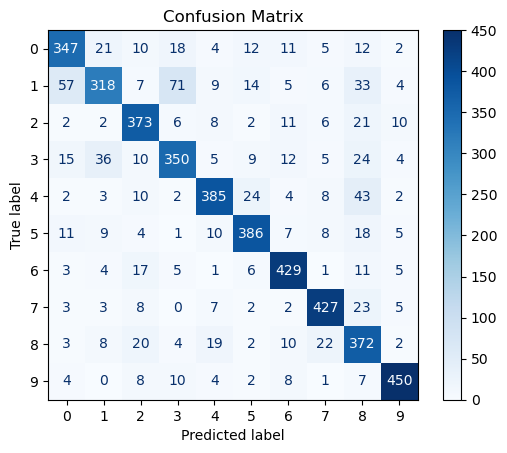

In [16]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




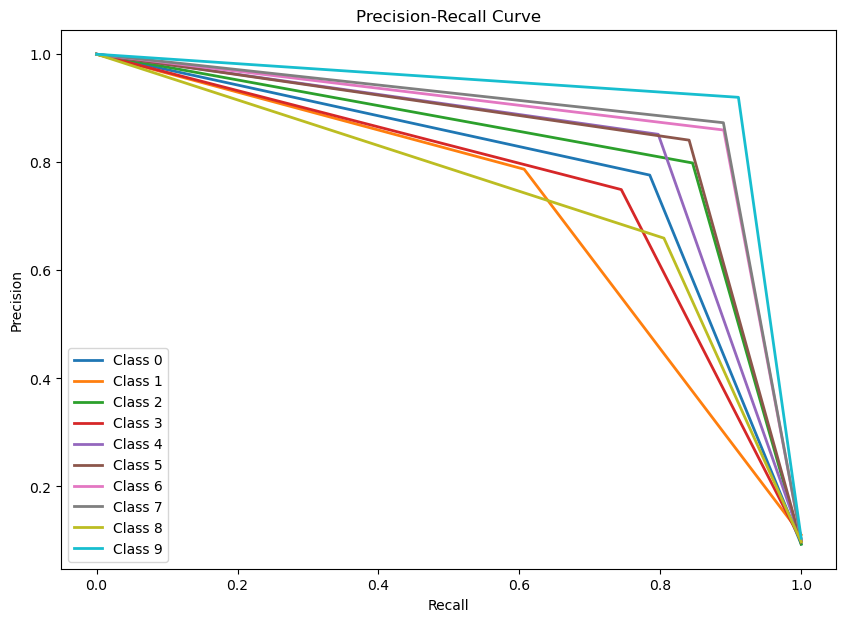

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris




# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    # Get ROC curve metrics for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random classifier (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()


NameError: name 'y_pred_prob' is not defined

<Figure size 1000x700 with 0 Axes>